In [226]:
#Importing phydrus
#get libraries
import os

import phydrus as ps

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import numpy as np

In [227]:
#Doing working directory stuff

#set working directory manually (I'm sure there is a better way to do this)
#os.chdir('C:\\Users\\meghanrobinson\\Downloads\\Modeling\\PHydrusTest\\PipelineStructure')

#give path to exe file
exe = os.path.join(os.getcwd(), "H1D_CALC.EXE")

#name the folder files will fill
main_level = os.path.normpath(os.path.join(os.getcwd(), os.pardir))
newfolder = 'Python_RBundle_12-16'
ws = os.path.join(main_level, '3_Results', newfolder)

In [228]:
#read in csvs

#Atmospheric Input
atm = pd.read_csv(os.path.join(main_level, '1_Input', 'AtmosphBoundary.csv'))
days = len(atm['date']) #save length of days column for later steps

#create new dataframe to manipulate to be exactly what is needed for PHydrus (keeping old version w/ temperature info for now)
atm2 = atm.drop(columns=['date','temp.mean.agr_c', 'min_temp_c', 'max_temp_c'], axis=1)

#these are required column names: 'tAtm', 'Prec', 'rSoil', 'rRoot', 'hCritA', 'rB', 'hB', 'hT'
atm2 = atm2.rename(columns={'Unnamed: 0':'tAtm', 'pet_mm':'rSoil', 'precip_mm':'Prec'}) #rename columns that are there
atm2['rRoot'] = 0 #no roots right now so no transpiration
atm2['hCritA']= 1000000 #max allowed surface head, this is hydrus default
atm2['rB']= 0 #bottom flux, is zero for free drainage boundary condition
atm2['hB']= 0 #groundwater level, is zero if model is not being run with groundwater
atm2['hT']= 0 #surface pressure head, zero if model uses free drainage

#rearrange to match format input
atm2 = atm2[['tAtm', 'Prec', 'rSoil', 'rRoot', 'hCritA', 'rB', 'hB', 'hT']]

#Van Genuchten parameters
vgs = pd.read_csv(os.path.join(main_level, '1_Input', 'VGParams.csv'))
vgs_use= vgs.iloc[0, [2,3,4,5,6,7]] #take one row (CHANGE 0 TO ROW NUMBER TO GET DIFFERENT ROW)
vglist = list(vgs_use)

#Observation Nodes
obs = pd.read_csv(os.path.join(main_level, '1_Input', 'ObservationInput.csv'))
obspts = obs.iloc[:, 2]
obspts= obspts*-1
obslist = list(obspts)

#Timestep list 
timesteps = [0.4] #one that intentionally doesn't work to test
timesteps2 = [0.4, 0.001, 0.003, 0.005, 0.006, 0.0001, 0.0003, 0.0004, 0.01, 0.00002,
             0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00009, 0.0002, 0.0007, 0.0009,
             0.0055, 0.0065, 0.00015, 0.00055, 0.00095] #actual good time steps

INFO: Directory c:\Users\meghanrobinson\Downloads\Modeling\PHydrusTest\Hydrus\PipelineStructure\3_Results\Python_RBundle_12-16 created
INFO: Successfully wrote c:\Users\meghanrobinson\Downloads\Modeling\PHydrusTest\Hydrus\PipelineStructure\3_Results\Python_RBundle_12-16\SELECTOR.IN
INFO: Successfully wrote c:\Users\meghanrobinson\Downloads\Modeling\PHydrusTest\Hydrus\PipelineStructure\3_Results\Python_RBundle_12-16\PROFILE.DAT
INFO: Successfully wrote c:\Users\meghanrobinson\Downloads\Modeling\PHydrusTest\Hydrus\PipelineStructure\3_Results\Python_RBundle_12-16\ATMOSPH.IN
INFO: Hydrus-1D Simulation Successful.
c:\Users\meghanrobinson\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
c:\Users\meghanrobinson\AppData\Local\Python\pythoncore-3.14-64\Lib\

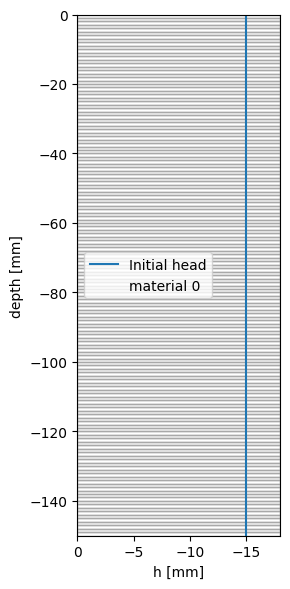

In [229]:
#Do model run

#loop iterating through time steps

for i in range(len(timesteps2)):
    #basic model info (name, units)
    ml = ps.Model(exe_name=exe, #telling it to use single porosity exe
              ws_name=ws, #folder to create/fill (in 3_Results)
              name="model",
              mass_units="mmol", time_unit="days", length_unit="mm")
    #add time info
    times = ml.add_time_info(tinit=0, #first day
                         tmax=days, #last day
                         print_times=True, #true if want model to print t level info every day
                        # printinit= 1,
                         #printmax= 40,
                         #dtprint= 1,
                         dt=timesteps2[i], #initial time increment (this is what R iteratres through)
                         dtmax=0.5, #max time increment (didn't change)
                         #printinit=120 #this would specify when to start printing t level info
                        )
    
    #add atmosphere input to Hydrus?
    ml.add_atmospheric_bc(atm2)
    
    #add waterflow information for selector on model type, boundary conditions, can add groundwater here (didn't)
    ml.add_waterflow(model= 0, #single porosity
                 top_bc=3, #top boundary condition is atmospheric with runoff
                 bot_bc=4, #bottom boundary condition is free drainage
                 )
    
    #this is a dataframe for soil materials, n=1 is number of materials
    m = ml.get_empty_material_df(n=1)
    
    #these are vg parameters for each depth
    m.loc[1] = vglist
    
    #add materials to function
    ml.add_material(m)
    
    #create soil profile
    profile = ps.create_profile(bot= -150, #depth of soil profile
                            dx= 1, #grid cells 1 cm
                            h=-15 #intial pressure head
                           )
    
    #profile.loc[75:150, "Mat"] = 2 #depth to start second soil material
    #add  profile to model
    ml.add_profile(profile)
    
    #observations nodes
    ml.add_obs_nodes(obslist)
    
    #write out input files
    ml.write_input()
    
    #run Hydrus!
    rs = ml.simulate()

    #check if model ran completely
    #first step: read in output
    tlevel = ml.read_tlevel()

    #check that output length equals input length, if TRUE stop loop, if FALSE keep going
    if len(tlevel) == days:
        ml.plots.profile()
        break
    else:
        if i == len(timesteps2)-1:
            failed = pd.DataFrame()
            failed.to_csv(os.path.join(main_level, '3_Results', newfolder, 'FAILED.csv'))


c:\Users\meghanrobinson\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
c:\Users\meghanrobinson\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
c:\Users\meghanrobinson\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\phydrus\read.py:259: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = read_csv(path, skiprows=start, index_col=0, nrows=end - start - 1,


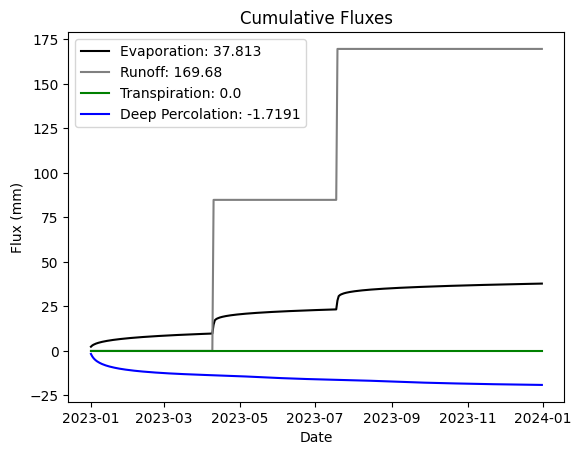

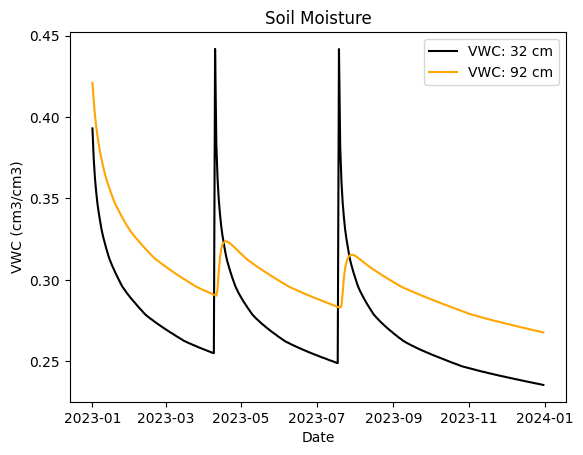

In [230]:
#Read in data and plot!
if ("FAILED.csv" in os.listdir(os.path.join(main_level, '3_Results', newfolder))) == False:
    
    #read in t level and obs node data
    tlevel = ml.read_tlevel(usecols= ['Time','rTop', 'rRoot', 'vTop', 'vRoot', 'vBot', 'sum(rTop)', 'sum(rRoot)', 'sum(vTop)',
'sum(vRoot)', 'sum(vBot)', 'hTop', 'hRoot', 'hBot', 'RunOff', 'sum(RunOff)', 'Volume', 'sum(Infil)', 'sum(Evap)', 'Cum(WTrans)'])
    obsnode = ml.read_obs_node()

    #make obs node data into a dataframe
    allobs = pd.DataFrame()
    
    for i in range(len(obslist)):
       nodenum = obslist[i]*-1+1
       obstemp =obsnode[nodenum]
       obstemp= obstemp.rename(columns={'h':f"h{nodenum}",
                             'theta':f"theta{nodenum}",
                             'Temp':f"temp{nodenum}"})
       allobs = pd.concat([allobs, obstemp], axis=1)

    #merge data to create csv file
    output = pd.concat([tlevel, allobs], axis=1)
    outputr = output.reset_index(drop=True)
    alldata = pd.concat([atm, outputr], axis= 1)


    alldata.to_csv(os.path.join(main_level, '3_Results', newfolder, 'HydrusMergedData.csv'))
    
    #make a new folder for plots to fill
    if not os.path.exists(os.path.join(main_level, '3_Results', newfolder, 'Plots')):
        os.mkdir(os.path.join(main_level, '3_Results', newfolder, 'Plots'))

    #plot cumulative fluxes
    xs= alldata['date']
    
    from datetime import datetime
    xs = pd.to_datetime(xs)
    y1 = alldata['sum(Evap)']
    y2= alldata['sum(RunOff)']
    y3= alldata['Cum(WTrans)']
    y4= alldata['sum(vBot)']
    
    #get maxes to include on plot
    emax = max(alldata['sum(Evap)'])
    tmax = max(alldata['Cum(WTrans)'])
    dmax = max(alldata['sum(vBot)'])
    rmax = max(alldata['sum(RunOff)'])
    
    #plt.plot(xs, y1, xs, y2, xs, y3, xs, y4)
    plt.plot(xs, y1, label= f"Evaporation: {emax}", c= "black")
    plt.plot(xs, y2, label= f"Runoff: {rmax}", c= "gray")
    plt.plot(xs, y3, label= f"Transpiration: {tmax}", c= "green")
    plt.plot(xs, y4, label= f"Deep Percolation: {dmax}", c= "blue")
    
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Flux (mm)")
    plt.title("Cumulative Fluxes")
 
    plt.savefig(os.path.join(main_level, '3_Results', newfolder, 'Plots', 'CumulativeFluxes.png'))
    plt.show()
    #plot soil moisture at specified depths
    y1 = alldata['theta32']
    y2= alldata['theta92']
    
    plt.plot(xs, y1, label= "VWC: 32 cm", c= "black")
    plt.plot(xs, y2, label= "VWC: 92 cm", c= "orange")
    
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("VWC (cm3/cm3)")
    plt.title("Soil Moisture")

    plt.savefig(os.path.join(main_level, '3_Results', newfolder, 'Plots', 'SoilMoisture.png'))
    plt.show()
    

